In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np
import tensorflow_model_optimization as tfmot

set_seed(1234)

2023-09-01 00:50:52.925545: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 00:50:52.955987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 00:50:53.521126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [2]:
dataset_name = DatasetName.RADIOML_2016
radioml2016b_path = cur_dir + "/data/radioml_2016/RML2016.10b.dat"
radioml2016a_path = cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl"
dataset_path = os.path.abspath(radioml2016b_path)
radioml_ds = make_sigmod_ds(dataset_name)
radioml_ds.load(dataset_path, normalize=False)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)
print(f"Modulations: {radioml_ds.get_modulations()}")

{'8PSK': 0, 'AM-DSB': 1, 'BPSK': 2, 'CPFSK': 3, 'GFSK': 4, 'PAM4': 5, 'QAM16': 6, 'QAM64': 7, 'QPSK': 8, 'WBFM': 9}
Modulations: ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [3]:

# idx = 1000

# print(radioml_ds.get_data()[idx].shape)
# print(np.min(radioml_ds.get_data()[idx]))
# print(np.max(radioml_ds.get_data()[idx]))
# print(np.mean(radioml_ds.get_data()[idx]))

# print(radioml_ds.get_data().shape)
# print(np.min(radioml_ds.get_data()))
# print(np.max(radioml_ds.get_data()))
# print(np.mean(radioml_ds.get_data()))
# print(np.std(radioml_ds.get_data()))

# Create Model
Create convolutional model

In [4]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName, EncoderTransformerConfiguration, EncoderLayerConfiguration
from evaluation.results_serialization import load_results

model_name = "enc_v3_small_radio_ml16b_normalized"
train_model = True
q_aware = True

quantize_model = tfmot.quantization.keras.quantize_model

if train_model:
    encoder_configuration = EncoderTransformerConfiguration(
        input_shape=(128, 2),
        n_classes=len(radioml_ds.get_modulations()),
        cnn_kernel_sizes=[33],
        cnn_output_channels=[32],
        cnn_paddings=["same"],
        encoder_layer=EncoderLayerConfiguration(
            h=4,
            d_k=32,
            d_v=32,
            d_model=32,
            d_ff=128,
            n=4,
        ),
        avg_size=32,
        dense_sizes=[96],
    )

    model_configuration = encoder_configuration

    model = make_sigmod_model(ModelName.ENCODER_TRANSFORMER_1D_V010, model_configuration)

    model.summary()

else:
    results = load_results(model_name + "_results/", load_model=True)
    model = results["model"]
    
# if q_aware:
#     model = quantize_model(model)

2023-09-01 00:51:06.700328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-01 00:51:06.717507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-01 00:51:06.717680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 CNN0_ (Conv1D)              (None, 128, 32)           2144      
                                                                 
 RELU0_ (ReLU)               (None, 128, 32)           0         
                                                                 
 ENC1_ (SigModEncoder)       (None, 128, 32)           50816     
                                                                 
 AVG1_ (AveragePooling1D)    (None, 4, 32)             0         
                                                                 
 FLT1_ (Flatten)             (None, 128)               0         
                                                                 
 FC0_ (Dense)                (None, 96)                12384 

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [5]:
import tensorflow as tf

def step_decay(epoch):
    # lrate = 0.001
    # factor = epoch // 8
    # lrate /= 10**factor
    return 0.001
    lrate = 0.001
    if epoch >= 16:
        lrate /= 10
    if epoch >= 24:
        lrate /= 4
    if epoch >= 32:
        lrate /= 4
    if epoch >= 40:
        lrate /= 2
    # factor = epoch // 8
    # lrate /= 10**factor
    return lrate


if train_model:
    lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # N_EPOCHS = 16
    N_EPOCHS = 10
    # N_EPOCHS = 20
    # N_EPOCHS = 7
    BATCH_SIZE = 256

    h = model.fit(
        splitted_radioml_ds.train.data,
        splitted_radioml_ds.train.labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
        callbacks=[lrate]
    )


Epoch 1/10


2023-08-31 19:52:38.342354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-31 19:52:38.861693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-31 19:52:38.924839: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1154ccd5d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-31 19:52:38.924864: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-08-31 19:52:38.928698: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-31 19:52:39.016642: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

3750/3750 [==============================] - 196s 50ms/step - loss: 1.3436 - accuracy: 0.4680 - val_loss: 1.0720 - val_accuracy: 0.5745 - lr: 0.0010
Epoch 2/10
3750/3750 [==============================] - 200s 53ms/step - loss: 1.0434 - accuracy: 0.5888 - val_loss: 1.0097 - val_accuracy: 0.6003 - lr: 0.0010
Epoch 3/10
3750/3750 [==============================] - 207s 55ms/step - loss: 0.9811 - accuracy: 0.6158 - val_loss: 0.9436 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 4/10
3750/3750 [==============================] - 212s 57ms/step - loss: 0.9499 - accuracy: 0.6293 - val_loss: 0.9650 - val_accuracy: 0.6236 - lr: 0.0010
Epoch 5/10
3750/3750 [==============================] - 216s 58ms/step - loss: 0.9311 - accuracy: 0.6375 - val_loss: 0.9261 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 6/10
3750/3750 [==============================] - 212s 57ms/step - loss: 0.9199 - accuracy: 0.6424 - val_loss: 0.9202 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 7/10
3750/3750 [=============================

# Evaluation
Check train plots, confusion matrices, snr to accuracy

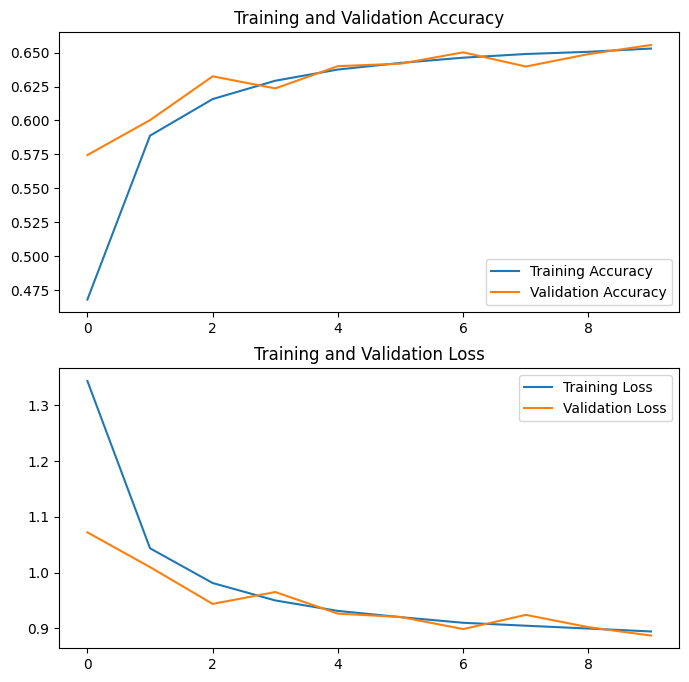

In [11]:
if train_model:
    from evaluation.vizualization import plot_train, plot_snr_to_acc
    plot_train(h.history)

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.65625}
8PSK test accuracy: 0.6680745341614907
AM-DSB test accuracy: 0.6767294562803323
BPSK test accuracy: 0.7220093302232589
CPFSK test accuracy: 0.7138127948357196
GFSK test accuracy: 0.6971580081199767
PAM4 test accuracy: 0.7259860983167239
QAM16 test accuracy: 0.6692165433759247
QAM64 test accuracy: 0.7696269834676415
QPSK test accuracy: 0.5997609493724921
WBFM test accuracy: 0.3185862785862786
Confusion matrix:
[[8067  456  283 1203  233   86  361  298  772  316]
 [ 935 8227  538  889  296   33   69   15  369  786]
 [ 689  124 8667  875  175  474  107   46  551  296]
 [1176  342  456 8625  382   46  115  135  583  223]
 [ 672  612  451  902 8414   56   87   28  323  524]
 [ 860  161  673  571  170 8669  153   53  359  272]
 [ 970  180  422  576  199  111 7961  882  438  157]
 [ 969  212   93  455  120  104  434 9264  317   69]
 [1389  323  584 1111  301   68  289  369 7025  254]
 [ 841 4914  708  716  452   41   93   1

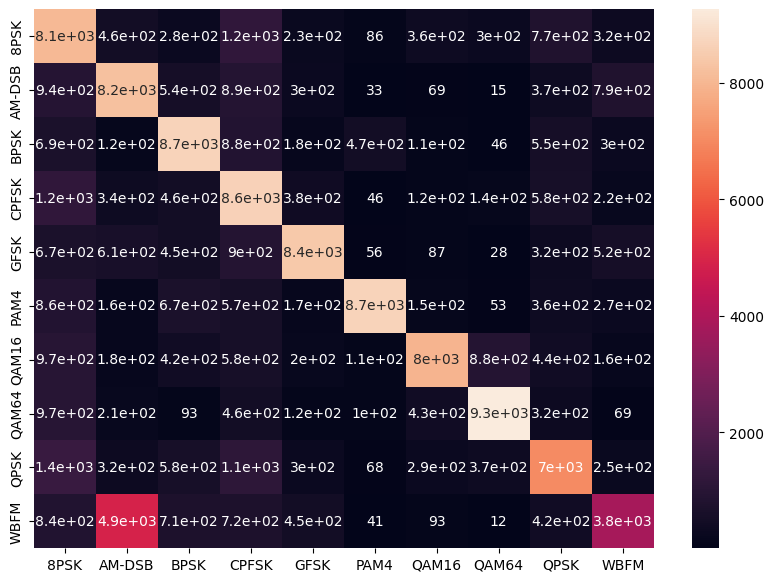

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.655125}
8PSK test accuracy: 0.6627916632068421
AM-DSB test accuracy: 0.6784408244680851
BPSK test accuracy: 0.7200431213201758
CPFSK test accuracy: 0.7159980023306143
GFSK test accuracy: 0.6925489531236755
PAM4 test accuracy: 0.7277777777777777
QAM16 test accuracy: 0.6742028007423655
QAM64 test accuracy: 0.7719571089465499
QPSK test accuracy: 0.5881029742564359
WBFM test accuracy: 0.3150742387383609
Confusion matrix:
[[7982  476  302 1207  230   90  352  319  765  320]
 [ 860 8163  501  895  282   46   58   15  367  845]
 [ 703  132 8683  852  176  490  112   52  579  280]
 [1142  377  452 8602  345   67  132  102  576  219]
 [ 667  576  484  899 8170   57   93   24  351  476]
 [ 861  143  672  599  184 8777  130   42  409  243]
 [ 933  173  378  580  208  116 7992  889  434  151]
 [ 951  233   78  463  143  113  449 9431  289   67]
 [1431  331  640 1152  344   68  305  423 7059  250]
 [ 795 4960  737  674  450   46   87   

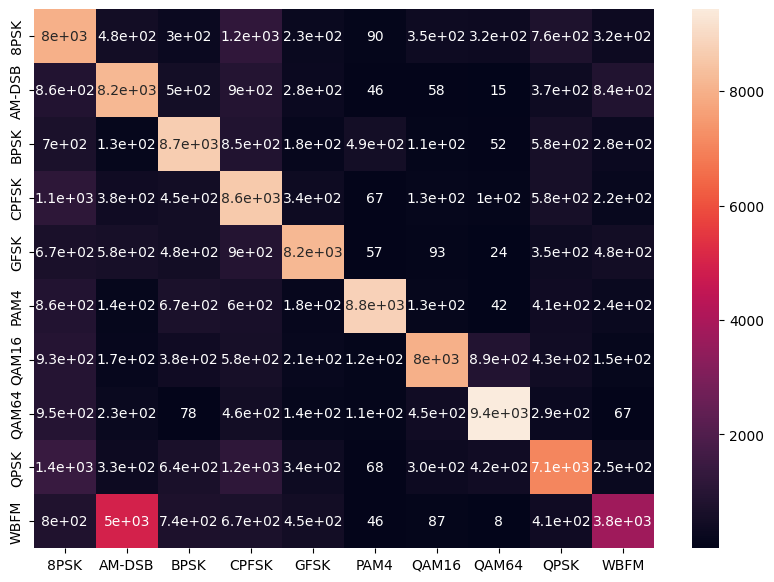

In [12]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

In [13]:
snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)

SNR: -20 -- Overall test accuracy: 0.18501402871761016
SNR: -18 -- Overall test accuracy: 0.15142952127659576
SNR: -16 -- Overall test accuracy: 0.18671363865123303
SNR: -14 -- Overall test accuracy: 0.22125377137110291
SNR: -12 -- Overall test accuracy: 0.22607397578371205
SNR: -10 -- Overall test accuracy: 0.3610554442217769
SNR: -8 -- Overall test accuracy: 0.4445
SNR: -6 -- Overall test accuracy: 0.5490162822252375
SNR: -4 -- Overall test accuracy: 0.7615883037049344
SNR: -2 -- Overall test accuracy: 0.807609594706369
SNR: 0 -- Overall test accuracy: 0.8908159894284771
SNR: 2 -- Overall test accuracy: 0.8946312092323131
SNR: 4 -- Overall test accuracy: 0.9235090037997687
SNR: 6 -- Overall test accuracy: 0.9303616484440707
SNR: 8 -- Overall test accuracy: 0.936910084451068
SNR: 10 -- Overall test accuracy: 0.9250911501491548
SNR: 12 -- Overall test accuracy: 0.9380425531914893
SNR: 14 -- Overall test accuracy: 0.9367088607594937
SNR: 16 -- Overall test accuracy: 0.9329543554589533
S

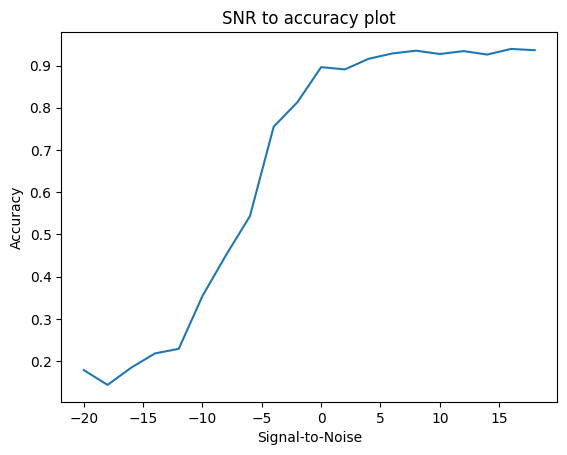

In [14]:
from evaluation.vizualization import plot_snr_to_acc

plot_snr_to_acc(snr_to_acc_val)


# Save results

In [15]:
# reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

from copy import deepcopy

# history = deepcopy(h.history)
# history["lr"] = list(map(lambda x: float(x), history["lr"]))
history = {}

dump_results(
    model_name + "_results/",
    model=model,
    model_config=model_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    short_description="Smaller + dense, 10 epochs adam, lr==0.001",
    dump_model=True,
)

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

In [5]:
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_snr_to_acc

model_path = f"{model_name}_results/model_original"
model.save(model_path)

# model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)

# cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
#     model_tflile_no_quant,
#     splitted_radioml_ds.test.data,
#     splitted_radioml_ds.test.labels,
#     radioml_ds.get_modulations(),
#     predict_func=predict_tflite,
# )

# snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
#     model_tflile_no_quant,
#     splitted_radioml_ds.test.data,
#     splitted_radioml_ds.test.labels,
#     radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
#     predict_func=predict_tflite,
# )
# plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

2023-09-01 00:51:13.279880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,128,32]
	 [[{{node inp}}]]
2023-09-01 00:51:13.308950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,128,32]
	 [[{{node inp}}]]
2023-09-01 00:51:14.287622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inp' with dtype float and shape [?,128,32]
	 [[{{node inp}}]]
2023-09-01 00:51:14.31628

INFO:tensorflow:Assets written to: enc_v3_small_radio_ml16b_normalized_results/model_original/assets


INFO:tensorflow:Assets written to: enc_v3_small_radio_ml16b_normalized_results/model_original/assets


2023-08-12 00:21:41.886854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-12 00:21:41.886879: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-12 00:21:41.887037: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml16b_1_results/model_original
2023-08-12 00:21:41.888571: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-12 00:21:41.888584: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml16b_1_results/model_original
2023-08-12 00:21:41.892674: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-12 00:21:41.922947: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_1d_v012_small_radio_ml16b_1_results/model_original
2023-08-12 00:21:41.932638

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.5154583333333334}
8PSK test accuracy: 0.6540786749482401
AM-DSB test accuracy: 0.7727235337665542
BPSK test accuracy: 0.6334555148283906
CPFSK test accuracy: 0.5823884796821981
GFSK test accuracy: 0.39067031237053607
PAM4 test accuracy: 0.6403986265806884
QAM16 test accuracy: 0.5450571620712845
QAM64 test accuracy: 0.13608041870898063
QPSK test accuracy: 0.546486809527875
WBFM test accuracy: 0.2525571725571726
Confusion matrix:
[[7898 1268  690  176  458  100   97   17 1153  218]
 [1596 9394  149   16  251   10    4    0   76  661]
 [2301 1166 7604   31  415  210   17    0  175   85]
 [2205 1453  389 7037  442   63   30    0  278  186]
 [1956 1863  205   35 4715   30    8    1   90 3166]
 [1663 1027 1015   23  350 7647   21    0  119   76]
 [2037 1064  612  111  322  217 6484  141  707  201]
 [1287  886  553  103  200  194 6359 1638  651  166]
 [2451 1300  676  130  427   94   57    2 6401  175]
 [1676 6815  147   16  231  

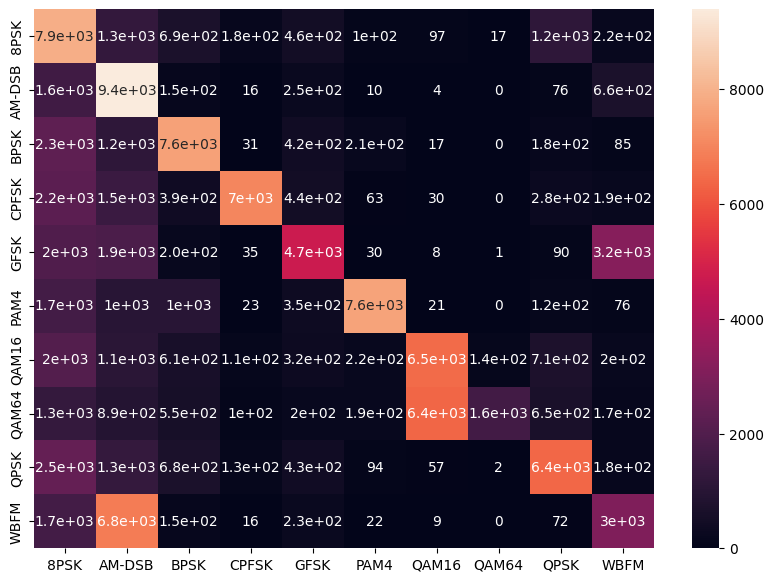

SNR: -20 -- Overall test accuracy: 0.10562799141772569
SNR: -18 -- Overall test accuracy: 0.11303191489361702
SNR: -16 -- Overall test accuracy: 0.11038416373091763
SNR: -14 -- Overall test accuracy: 0.1272209185383842
SNR: -12 -- Overall test accuracy: 0.14612705257920053
SNR: -10 -- Overall test accuracy: 0.19104876419505679
SNR: -8 -- Overall test accuracy: 0.24983333333333332
SNR: -6 -- Overall test accuracy: 0.3373473541383989
SNR: -4 -- Overall test accuracy: 0.522512045190231
SNR: -2 -- Overall test accuracy: 0.6469809760132341
SNR: 0 -- Overall test accuracy: 0.7277832837793194
SNR: 2 -- Overall test accuracy: 0.7526342197691922
SNR: 4 -- Overall test accuracy: 0.7779613414835619
SNR: 6 -- Overall test accuracy: 0.7981497056349874
SNR: 8 -- Overall test accuracy: 0.7878787878787878
SNR: 10 -- Overall test accuracy: 0.7823997348359297
SNR: 12 -- Overall test accuracy: 0.7817872340425532
SNR: 14 -- Overall test accuracy: 0.7921385742838108
SNR: 16 -- Overall test accuracy: 0.7789

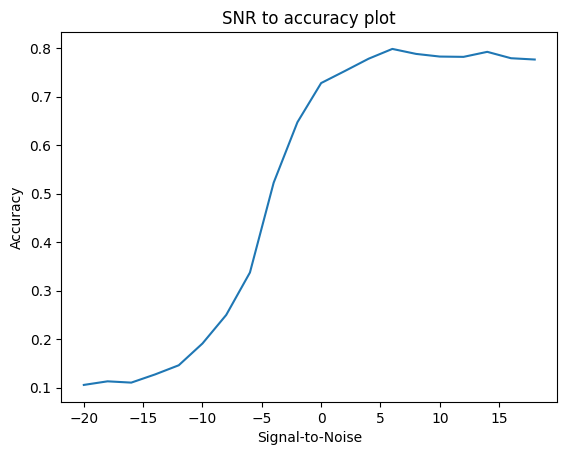

In [12]:
reload_module("deployment_tools")
from deployment_tools import to_tf_lite, predict_tflite

representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite)

In [13]:
interpreter = tf.lite.Interpreter(model_content=model_tflile)
print(interpreter.get_input_details()[0])
print(interpreter.get_output_details()[0])

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   2], dtype=int32), 'shape_signature': array([ -1, 128,   2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0004541363741736859, -4), 'quantization_parameters': {'scales': array([0.00045414], dtype=float32), 'zero_points': array([-4], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 53, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [ ]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name,
    classes=radioml_ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


0it [00:00, ?it/s]

11it [00:00, 1542.02it/s]
